# Анализ сервиса аренды самокатов GoFast

<span style='font-size: 18px;'>Техническое задание:</span>

В распоряжении данные сервиса аренды самокатов GoFast о некоторых пользователях из нескольких городов, а также об их поездках. Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться без подписки, в таком случае абонентская плата отсутствует, стоимость одной минуты - 8 рублей, стоимость старта поездки - 50 рублей. С подпиской Ultra абонентская плата — 199 рублей в месяц, стоимость одной минуты - 6 рублей, стоимость старта поездки - бесплатно. Продакт-менеджеры сервиса хотят увеличить количество пользователей с подпиской. Необходимо проанализировать данные и проверить некоторые гипотезы, которые могут помочь вырасти бизнесу.
 
<span style='font-size: 18px;'>План работы:</span>

1. Изучение общей информации датафреймов:
    - Пропущенные значения
    - Неправильные типы данных
    - Выбросы и аномалии
    - Явные дубликаты
    
    
2. Предобработка данных:
    - Удаление возможных дубликатов
    - Изменение типов данных
    - Добавление номера месяца в датафрейм поездки
    
    
3. Исследовательский анализ данных.
    - Обработка аномальных значений
    - Описать и визуализировать:
        - Частоту встречаемости городов
        - Соотношение пользователей с подпиской и без подписки
        - Возраст пользователей
        - Расстояние, которое пользователь преодолел за одну поездку
        - Продолжительность поездок

4. Объединение данных:
    - Обьединение трех таблиц в один датафрейм
        - Создание двух датафреймов: с подпиской и без
    - Визуализация информации о расстоянии и времени поездок для пользователей обеих категорий.

      
5. Подсчёт выручки:
    - Создать датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными.
        - Найти для каждого пользователя за каждый месяц:
            - Суммарное расстояние
            - Количество поездок
            - Суммарное время
    - Добавить столбец с помесячной выручкой, которую принёс каждый пользователь.

    
6. Проверка гипотез:
    -  Тратят ли пользователи с подпиской больше времени на поездки?
    -  Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?
    -  Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?





<span style='font-size: 18px;'>Описание данных:</span>

В основных данных есть информация о пользователях, их поездках и подписках.

1. Пользователи — users_go:
    - `user_id` - уникальный идентификатор пользователя
    - `name` - имя пользователя
    - `age` - возраст
    - `city` - город
    - `subscription_type` - тип подписки (free, ultra)
2. Поездки — rides_go:
    - `user_id` -уникальный идентификатор пользователя
    - `distance` -расстояние, которое пользователь проехал в текущей сессии (в метрах)
    - `duration` -продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
    - `date` -дата совершения поездки
3. Подписки — subscriptions_go:
    - `subscription_type` - тип подписки
    - `minute_price` - стоимость одной минуты поездки по данной подписке
    - `start_ride_price` - стоимость начала поездки
    - `subscription_fee` - стоимость ежемесячного платежа

### 1. Изучение общей информации

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import numpy as np

#### 1.1 Датасет пользователи

In [3]:
try:
    user_go = pd.read_csv('datasets/users_go.csv')
except:
    user_go = pd.read_csv('/datasets/users_go.csv')
    
user_go.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [4]:
user_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [5]:
(user_go.isna().mean()*100).sort_values(ascending=False)

user_id              0.0
name                 0.0
age                  0.0
city                 0.0
subscription_type    0.0
dtype: float64

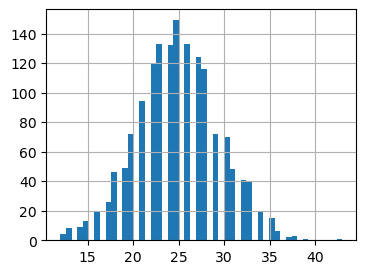

In [6]:
user_go['age'].hist(figsize=(4, 3), bins=50)
plt.show()

In [7]:
print('Количество явных дубликатов:', user_go[user_go.duplicated(subset=['user_id'])]['user_id'].count())

Количество явных дубликатов: 31


#### 1.2 Датасет поездки

In [8]:
try:
    rides_go = pd.read_csv('datasets/rides_go.csv')
except:
    rides_go = pd.read_csv('/datasets/rides_go.csv')

rides_go.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [9]:
rides_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [10]:
(rides_go.isna().mean()*100).sort_values(ascending=False)

user_id     0.0
distance    0.0
duration    0.0
date        0.0
dtype: float64

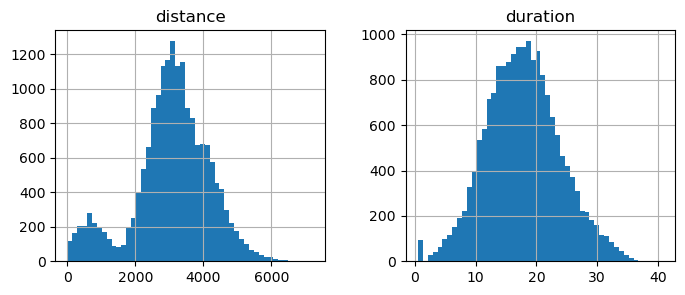

In [11]:
rides_go[['distance', 'duration']].hist(figsize=(8, 3), bins=50)
plt.show()

In [12]:
print('Количество явных дубликатов:', rides_go[rides_go.duplicated()]['user_id'].count())

Количество явных дубликатов: 0


#### 1.3 Датасет подписки

In [13]:
try:
    subscriptions_go = pd.read_csv('datasets/subscriptions_go.csv')
except:
    subscriptions_go = pd.read_csv('/datasets/subscriptions_go.csv')
    
subscriptions_go.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


**Вывод:**

Пропусков в таблицах не обнаружено.

Неправильные типы данных:
* user_go:
    * Тип подписки `subscription_type` можно изменить на True/False - это сэкономит ресурсы.
* rides_go:
    * Дата `date` в строковом формате.
* subscriptions_go:
    * Тип подписки `subscription_type` можно сделать булевым, аналогично с user_go.
 
Выбросы и аномалии:
* user_go:
    * Возраст `age` имеет аномалию в виде несовершеннолетних.
* rides_go:
    * Продолжительность сессии `duration` имеет аномальные значения - 0.5 минуты.
 
В таблице user_go найдены явные дубликаты.

### 2. Предобработка данных

#### 2.1 Удаление дубликатов

In [14]:
user_go.drop_duplicates(subset=['user_id'], inplace=True)
user_go[user_go.duplicated(subset=['user_id'])]['user_id'].count()

0

#### 2.2 Удаление аномальных значений

In [15]:
rides_go.query('distance > 0.5')

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28
...,...,...,...,...
18063,1534,3781.098080,19.822962,2021-11-04
18064,1534,2840.423057,21.409799,2021-11-16
18065,1534,3826.185507,18.435051,2021-11-18
18066,1534,2902.308661,16.674362,2021-11-27


#### 2.3 Изменение типов данных

In [16]:
user_go['subscription_type'] = np.where(user_go['subscription_type'] == 'ultra', True, False)
subscriptions_go['subscription_type'] = np.where(subscriptions_go['subscription_type'] == 'ultra', True, False)

user_go.rename({'subscription_type':'is_subscription'}, axis=1, inplace=True)
subscriptions_go.rename({'subscription_type':'is_subscription'}, axis=1, inplace=True)

rides_go['date'] = pd.to_datetime(rides_go['date'], format='%Y-%m-%d')

#### 2.4 Добавления вспомогающего столбца

In [17]:
rides_go['month'] = rides_go['date'].dt.month

**Вывод:**

Явные дубликаты удалены, типы данных изменены. С точки зрения хранения, подходящий тип данных оптимизирует место в памяти. В датафреймах user_go и subscriptions_go подписка была переведена в тип данных boolean (логический). В датафрейме rides_go дата была переведена в datetime64. Также в столбцах были изменены названия для визуального понимания, что перед нами столбец из логических значений. В таблицу rides_go был добавлен столбец month с нумерацией месяца.

### 3. Исследовательский анализ данных

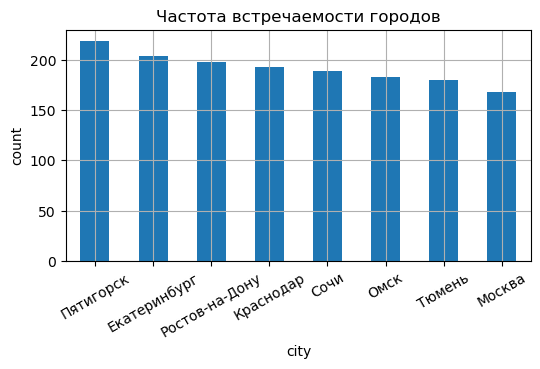

In [18]:
plt.figure(figsize=(6, 3))

(user_go['city']
 .value_counts(ascending=False)
 .plot(kind='bar')
)

plt.grid()
plt.title('Частота встречаемости городов')
plt.xticks(rotation=30)
plt.xlabel('city')
plt.ylabel('count')

plt.show()

Чаще всего сервисом пользуются в Пятигорске, реже - в Москве. Вероятно, в Москве пользуются меньше из-за большой конкуренции сервисов шеринга самокатов.

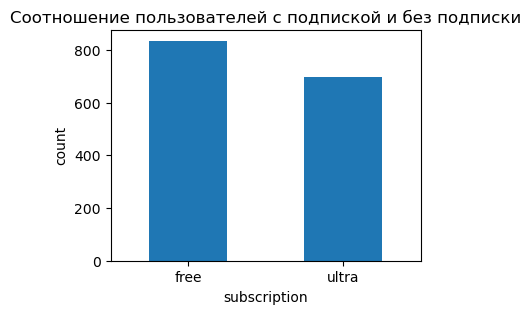

In [19]:
plt.figure(figsize=(4, 3))

(user_go['is_subscription']
 .value_counts()
 .plot(kind='bar')
)

plt.title('Соотношение пользователей с подпиской и без подписки')
plt.xticks([0, 1], ['free', 'ultra'],rotation=0)
plt.xlabel('subscription')
plt.ylabel('count')

plt.show()

Пользователей без подписки - 835, что почти на 20% больше, чем с подпиской - 699.

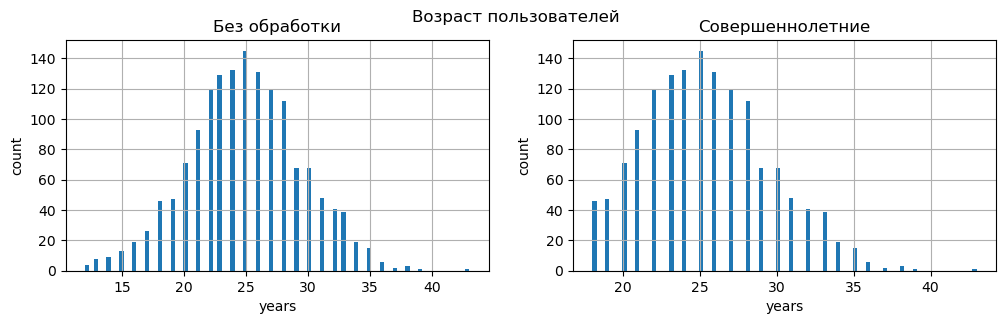

In [20]:
plt.figure(figsize=(12, 3))
plt.suptitle('Возраст пользователей')

plt.subplot(1, 2, 1)
plt.title('Без обработки')
plt.xlabel('years')
plt.ylabel('count')
user_go['age'].hist(bins=90)

user_go.query('age >= 18', inplace=True)

plt.subplot(1, 2, 2)
plt.title('Совершеннолетние')
plt.xlabel('years')
plt.ylabel('count')
user_go['age'].hist(bins=90)

plt.show()

Возраст пользователей распределен около нормального распределения. Несовершеннолетние пользователи были убраны из выборки, по случаю законодательства РФ - с 1 марта 2023 года аренда самокатов осуществляется только лицами достигшими совершеннолетия. 

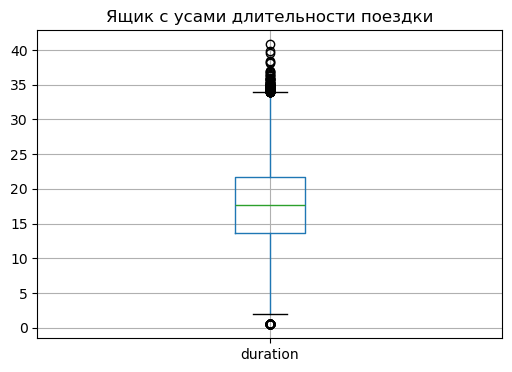

In [21]:
plt.figure(figsize=(6, 4))

rides_go.boxplot(column='duration')

plt.title('Ящик с усами длительности поездки')
plt.show()

In [22]:
rides_go.query('duration < 1')['distance'].describe()

count      95.000000
mean     5113.176549
std       658.254104
min      4030.308008
25%      4611.510820
50%      5052.769411
75%      5488.459099
max      7211.007745
Name: distance, dtype: float64

In [23]:
IQR = rides_go['duration'].quantile(q=0.75) - rides_go['duration'].quantile(q=0.25)
quan3_iqr = rides_go['duration'].quantile(q=0.75) + 1.5*IQR

rides_go.query('duration > @quan3_iqr')['distance'].describe()

count      82.000000
mean     4476.718008
std       517.744755
min      3497.968627
25%      4140.603539
50%      4420.872426
75%      4799.849483
max      6436.625605
Name: distance, dtype: float64

Среди продолжительных поездок, которые зафиксированы как выбросы, аномальных дистанций нет. Вероятнее всего, шеринг самокатов также используется в туристических целях. Среди коротких поездок, менее одной минуты, наблюдаются дистанции от 4 до 7.2 км, что точно является аномалией.

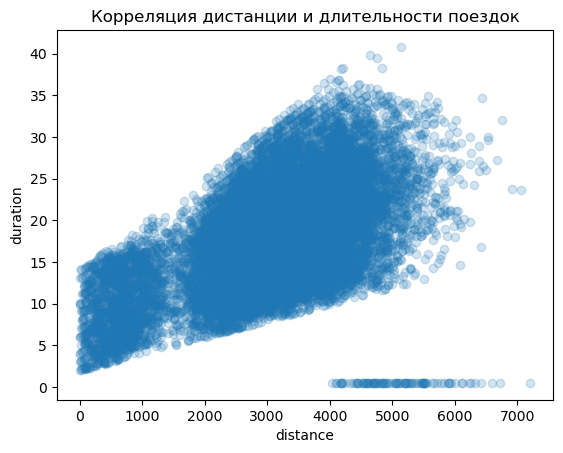

In [24]:
plt.scatter(rides_go['distance'], rides_go['duration'], alpha=0.2)

plt.title('Корреляция дистанции и длительности поездок')
plt.xlabel('distance')
plt.ylabel('duration')
plt.show()

Виден выброс с дистанцией более 4 км. и временем поездки равной 30 секундам. Также, на графике корреляции можем наблюдать аномально долгие по времени и короткие по дистанции поездки. 

In [25]:
# Функция для замены аномалий медианным значением категории.
def cetegories_median(df, clm1, clm2, n):
    series_filter = df.query(f'{clm1} == {n}')[clm2].astype(int)
    
    a = series_filter.min()
    b = series_filter.max()
    step = int(np.ceil((b-a)/10))
    
    for i in range(a, b, step):
        df.loc[(df[clm1] == n) & (df[clm2] > i) & (df[clm2] < i+step), clm1] = \
        df.query(f'(@i < {clm2} < @i+@step) & ({clm1} != {n})')[clm1].median()

    return df

In [26]:
rides_go.pipe(cetegories_median, 'duration', 'distance', 0.5).query('duration < 1')['user_id'].count()

0

In [27]:
rides_go.query('((distance/25000*60) > duration)')

,user_id,distance,duration,date,month
9099,894,5507.980168,13.015960,2021-11-30,11
14241,1261,5170.970011,12.341940,2021-01-29,1
14310,1265,6088.051913,14.595969,2021-09-22,9
15332,1341,5215.548311,12.431097,2021-08-29,8


В сводной таблице предствалены поездки со скоростью, превыщающей ограничение. Так как скорость не превышает 25.4 км/ч., то можем считать эти данные в пределах нормы.

In [28]:
rides_go.query('(distance/5000*60 + 1) > duration', inplace=True)

Аномально быстрые по времени поездки были заменены на медианные значения по категориям дистанций. Аномально долгие по времени и короткие по дистанции поездки были убраны из датафрейма фильтром.

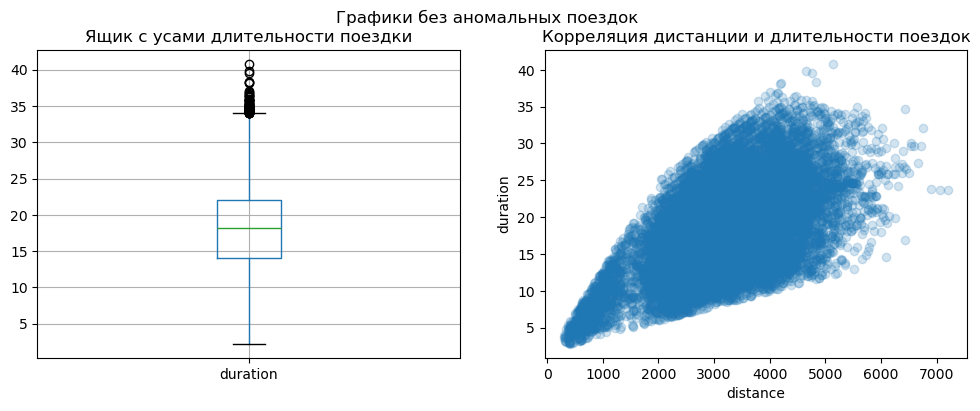

In [29]:
plt.figure(figsize=(12, 4))
plt.suptitle('Графики без аномальных поездок')

plt.subplot(1, 2, 1)
rides_go.boxplot(column='duration')
plt.title('Ящик с усами длительности поездки')

plt.subplot(1, 2, 2)
plt.scatter(rides_go.query('(distance > 300) & ((distance/5000*60 + 1) > duration)')['distance'], rides_go.query('(distance > 300) & ((distance/5000*60 + 1) > duration)')['duration'], alpha=0.2)
plt.title('Корреляция дистанции и длительности поездок')
plt.xlabel('distance')
plt.ylabel('duration')

plt.show()

**Вывод:**

Севис шеринга самокатов GoFast ориентирован на города: Тюмень, Омск, Москва, Ростов-на-Дону, Краснодар, Пятигорск, Екатеринбург, Сочи. В разных городах сервисом пользуются примерно в одинаковых пропорциях. В Пятигорске и Екатеринбурге количество пользователей преобладает, в Москве их меньше всего. Пользователей без подписки на 20% больше, чем с подпиской ultra. Несовершеннолетние пользователи были удалены фильтром. Аномальные значения поездок по времени и дистанциям были удалены.

### 4. Объединение данных

In [30]:
print('Количество уникальных пользователей в датафрейме user_go:', user_go['user_id'].nunique())
print('Количество уникальных пользователей в датафрейме rides_go:', rides_go['user_id'].nunique())

Количество уникальных пользователей в датафрейме user_go: 1455
Количество уникальных пользователей в датафрейме rides_go: 1534


In [31]:
np.setdiff1d(rides_go['user_id'].unique(), user_go['user_id'].unique())

array([  21,   34,   35,   49,   67,   76,   84,  146,  152,  164,  176,
        183,  184,  233,  236,  238,  246,  269,  295,  306,  315,  322,
        345,  350,  353,  393,  412,  449,  455,  457,  467,  476,  479,
        508,  521,  526,  548,  554,  638,  665,  695,  716,  728,  754,
        780,  811,  887,  902,  934,  972,  981, 1022, 1028, 1049, 1054,
       1086, 1112, 1113, 1133, 1162, 1187, 1205, 1209, 1220, 1242, 1248,
       1250, 1269, 1272, 1283, 1334, 1378, 1379, 1464, 1475, 1476, 1477,
       1488, 1516], dtype=int64)

В таблице `rides_go` на 79 пользователей больше. Так как нас интересуют пользователи с подпиской и без, будем склеивать таблицы по `user_go`.

In [32]:
data = (user_go.sort_values(by='user_id', ascending=True)
        .merge(rides_go.sort_values(by=['user_id', 'date'], ascending=True),
               on='user_id',
               how='left')
        .merge(subscriptions_go,
               on='is_subscription',
               how='left')
       )

data.head(15)

,user_id,name,age,city,is_subscription,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,True,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,True,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,True,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,True,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,True,4028.687306,26.265803,2021-08-28,8,6,0,199
5,1,Кира,22,Тюмень,True,2770.890808,16.650138,2021-10-09,10,6,0,199
6,1,Кира,22,Тюмень,True,3039.020292,14.927879,2021-10-19,10,6,0,199
7,1,Кира,22,Тюмень,True,2842.118050,23.117468,2021-11-06,11,6,0,199
8,1,Кира,22,Тюмень,True,3412.690668,15.238072,2021-11-14,11,6,0,199
9,1,Кира,22,Тюмень,True,4031.020195,17.674448,2021-12-14,12,6,0,199


In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16157 entries, 0 to 16156
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   user_id           16157 non-null  int64         
 1   name              16157 non-null  object        
 2   age               16157 non-null  int64         
 3   city              16157 non-null  object        
 4   is_subscription   16157 non-null  bool          
 5   distance          16157 non-null  float64       
 6   duration          16157 non-null  float64       
 7   date              16157 non-null  datetime64[ns]
 8   month             16157 non-null  int32         
 9   minute_price      16157 non-null  int64         
 10  start_ride_price  16157 non-null  int64         
 11  subscription_fee  16157 non-null  int64         
dtypes: bool(1), datetime64[ns](1), float64(2), int32(1), int64(5), object(2)
memory usage: 1.3+ MB


Чтобы избежать возможных неприятностей после склейки, датафрейм `user_go` был отсортирован по увеличению столбца 'user_id'. Аналогично с датафреймом `rides_go`, дополнительно для удобства уникальные id были отсортированы по датам.

In [34]:
data_ultra = data.query('is_subscription == True')

data_ultra.sample(5)

,user_id,name,age,city,is_subscription,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
2621,313,Ильдар,31,Сочи,True,3017.138377,17.704752,2021-08-02,8,6,0,199
2550,303,Марат,32,Тюмень,True,2927.060475,22.635302,2021-11-18,11,6,0,199
3287,394,Алиса,31,Ростов-на-Дону,True,2988.020684,29.298295,2021-05-16,5,6,0,199
2530,301,Вячеслав,24,Ростов-на-Дону,True,2571.364103,20.285456,2021-09-03,9,6,0,199
1244,149,Лиана,18,Екатеринбург,True,3185.090053,19.925450,2021-02-25,2,6,0,199


In [35]:
data_free = data.query('is_subscription == False')

data_free.sample(5)

,user_id,name,age,city,is_subscription,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
10845,1103,Вадим,21,Краснодар,False,2426.234962,18.932100,2021-10-03,10,8,50,0
15562,1489,Алёна,30,Пятигорск,False,2213.136343,10.742435,2021-01-18,1,8,50,0
6170,721,Андрей,27,Пятигорск,False,2612.031051,11.706770,2021-01-13,1,8,50,0
14674,1415,Илья,21,Краснодар,False,2265.848783,9.155312,2021-06-13,6,8,50,0
14096,1372,Святослав,28,Краснодар,False,4264.522123,19.184349,2021-03-14,3,8,50,0


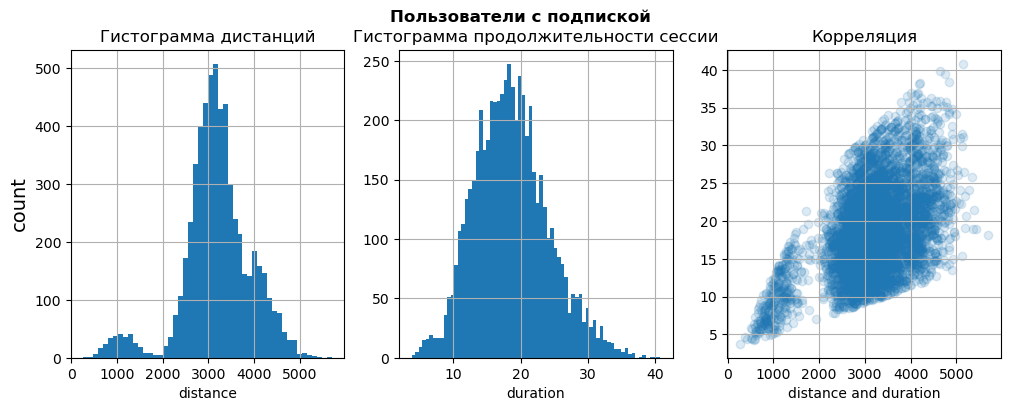

In [36]:
plt.figure(figsize=(12, 4))
plt.suptitle('Пользователи с подпиской', weight='heavy')

plt.subplot(1, 3, 1)
plt.title('Гистограмма дистанций')
plt.hist(data_ultra['distance'], bins=50)
plt.xlabel('distance')
plt.ylabel('count', fontsize=14)
plt.grid()

plt.subplot(1, 3, 2)
plt.title('Гистограмма продолжительности сессии')
plt.hist(data_ultra['duration'], bins=70)
plt.xlabel('duration')
plt.grid()

plt.subplot(1, 3, 3)
plt.title('Корреляция')
plt.scatter(data_ultra['distance'], data_ultra['duration'], alpha=0.15)
plt.xlabel('distance and duration')
plt.grid()

plt.show()

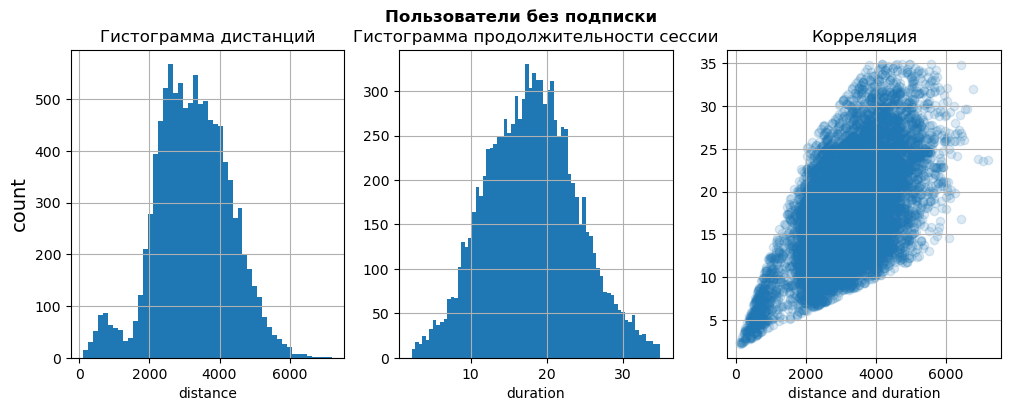

In [37]:
plt.figure(figsize=(12, 4))
plt.suptitle('Пользователи без подписки', weight='heavy')

plt.subplot(1, 3, 1)
plt.title('Гистограмма дистанций')
plt.hist(data_free['distance'], bins=50)
plt.xlabel('distance')
plt.ylabel('count', fontsize=14)
plt.grid()

plt.subplot(1, 3, 2)
plt.title('Гистограмма продолжительности сессии')
plt.hist(data_free['duration'], bins=70)
plt.xlabel('duration')
plt.grid()

plt.subplot(1, 3, 3)
plt.title('Корреляция')
plt.scatter(data_free['distance'], data_free['duration'], alpha=0.15)
plt.xlabel('distance and duration')
plt.grid()

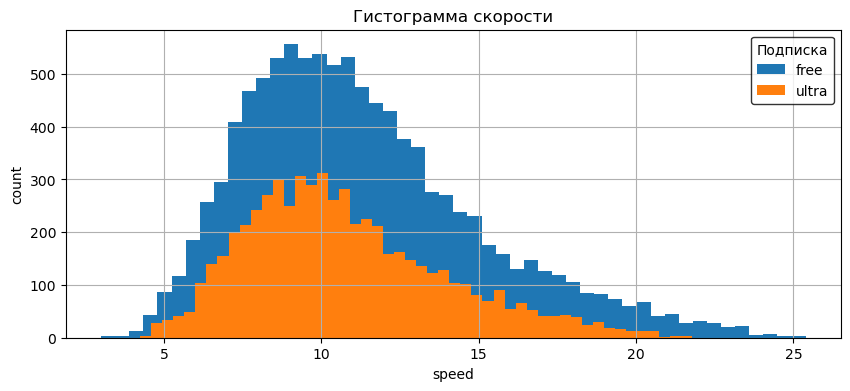

In [38]:
plt.figure(figsize=(10, 4))
plt.title('Гистограмма скорости')

plt.xlabel('speed')
plt.ylabel('count')

(data_free
 .apply(lambda x: (x['distance']*60)/(x['duration']*1000), axis=1)
 .hist(bins=50, label='free')
)

(data_ultra
 .apply(lambda x: (x['distance']*60)/(x['duration']*1000), axis=1)
 .hist(bins=50, label='ultra')
)

plt.legend(title='Подписка', edgecolor='black')
plt.show()

**Вывод:**

Пользователи с подпиской и без имеют похожие распределения. Пользователи с подпиской чаще арендуют самокат для дистанции в 3 км, когда пользователи без подписки для 2.5 - 3.5 км. Можно заметить, что пользователи без подписки арендовывают самокат на более большие дистанции и на менее короткие сессии, следовательно их скорость должна быть выше. Было проведено дописследование, пользователи с подпиской не разгоняются более 22 км/ч, когда пользователи без могут ехать до 25 км/ч.

### 5. Подсчёт выручки

In [39]:
df_agg = (pd.merge(data.pivot_table(index=['user_id', 'month'],
                                    values=['distance', 'duration'],
                                    aggfunc=['sum', 'count'])
         .drop(('count', 'distance'), axis=1),
         
        (data.assign(duration_ceil=lambda x: np.ceil(x['duration']))
                     .pivot_table(index=['user_id', 'month'],
                                  values=['duration_ceil',
                                          'minute_price',
                                          'start_ride_price',
                                          'subscription_fee'],
                                  aggfunc=['sum', 'mean'])
                     .drop([('sum', 'minute_price'),
                            ('sum', 'start_ride_price'),
                            ('sum', 'subscription_fee'),
                            ('mean', 'duration_ceil')], axis=1)),
                   
         on=('user_id', 'month')
                   
        ).assign(income=lambda x: (x[('sum', 'duration_ceil')] * x[('mean', 'minute_price')]) \
                 + (x[('mean', 'start_ride_price')] * x[('count', 'duration')]) + x[('mean', 'subscription_fee')])
          
         .drop([('sum', 'duration_ceil'),
                ('mean', 'minute_price'),
                ('mean', 'start_ride_price')], axis=1)
)

df_agg.columns = ['sum_distance', 'sum_duration', 'num_trips', 'is_subscription', 'income']
df_agg = df_agg.assign(is_subscription=lambda x: x['is_subscription'] == 199)

df_agg

sum_distance  sum_duration  num_trips  is_subscription  income
user_id month                                                                
1       1       7027.511294     41.416640          2             True   451.0
        4        754.159807      6.232113          1             True   241.0
        8       6723.470560     44.776802          2             True   475.0
        10      5809.911100     31.578017          2             True   391.0
        11      6254.808719     38.355540          2             True   439.0
...                     ...           ...        ...              ...     ...
1534    6       3214.021065     18.343604          1            False   202.0
        8       7622.453034     47.205960          2            False   484.0
        9       4928.173852     22.560373          1            False   234.0
        11     13350.015305     76.342174          4            False   824.0
        12      2371.711192     15.893917          1            False   178.0

[10398 rows x 5 columns]

**Вывод:**

Создан датафрейм с агрегированными данными. Он включает в себя статистику пользователей за каждый месяц, в котором была активность: преодоленная дистанция, суммарное время и количество поездок, флаг наличия подписки, выручка, которую принес пользователь.

### 6. Проверка гипотез

#### Гипотеза 1. Тратят ли пользователи с подпиской больше времени на поездки?

Нулевая гипотеза (H0): пользователи с подпиской и без тратят равное время на поездки\
Альтернативная гипотеза (H1): пользователи с подпиской тратят больше времени на поездки\
Уровень статистической значимости: 5%

In [40]:
alpha=0.05

res = st.ttest_ind(data_ultra['duration'],
             data_free['duration'],
             equal_var=False, # Выборки разных размеров.
             alternative='greater')

print('p-value:', res.pvalue)
print('Отвергаем нулевую гипотезу') if res.pvalue < alpha else print('Нет оснований отвергать нулевую гипотезу')

p-value: 1.1482021051605405e-11
Отвергаем нулевую гипотезу


Есть основание полагать, что пользователи с подпиской тратят больше времени на поездки.

#### Гипотеза 2: Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?

Нулевая гипотеза (H0): Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку равно 3130 метров\
Альтернативная гипотеза (H1): Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку меньше 3130 метров\
Уровень статистической значимости: 5%

In [41]:
target_value = 3130
alpha = 0.05

res = st.ttest_1samp(data_ultra['distance'],
                     target_value,
                     alternative='less')

print('p-value:', res.pvalue)
if res.pvalue < alpha:
    print('Отвергаем нулевую гипотезу. Среднее расстояние явно не превышает 3130 метров')
else:
    print('Нет оснований отвергать нулевую гипотезу. ')

p-value: 0.9999999148053914
Нет оснований отвергать нулевую гипотезу. 


Статистический односторонний тест показал, что объект исследования не меньше 3130 метров. А значит, наша изначальная гипотеза 'Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?' - отверглась.

Близкое к единице значение p-value не означает, что среднее расстояние равно 3130 метров. При одностороннем тесте вероятность уровня значимости приходится на одну сторону, следовательно среднее даже может быть больше.

#### Гипотеза 3: Больше ли выручка от пользователей с подпиской, чем выручка от пользователей без подписки?

Нулевая гипотеза (H0): Средняя выручка пользователей с подпиской и без равна\
Альтернативная гипотеза (H1): Средняя выручка от пользователей с подпиской больше, чем средняя выручка от пользователей без подписки\
Уровень статистической значимости: 5%

In [42]:
alpha = 0.05

res = st.ttest_ind(df_agg.query('is_subscription')['income'],
                   df_agg.query('~is_subscription')['income'],
                   equal_var=False,
                   alternative='greater')

print('p-value:', res.pvalue)

if res.pvalue < alpha:
    print('Отвергаем нулевую гипотезу.')
else:
    print('Нет оснований отвергать нулевую гипотезу.')

p-value: 1.433055040607375e-41
Отвергаем нулевую гипотезу.


По всей видимости, пользователи с подпиской действительно приносят больше выручки.

Представьте такую ситуацию:\
техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение.\
Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось.\
Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него.\
Какой тест вам понадобился бы для проверки этой гипотезы?

- Для данной гипотезы, нам понадобился бы тест о равенстве средних для зависимых выборок. Так как мы будем проверять гипотезу над данными до и после их преобразования, такой тест в `scipy.stats` называется `ttest_rel`.

**Вывод:**
- Тратят ли пользователи с подпиской больше времени на поездки?
    - Есть основание пологать, что пользователи с подпиской тратят больше времени на поездки.
- Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?
    - Гипотеза была отвергнута. Пользователи с подпиской проезжают в среднем дистанции равные или более 3130 метров.
- Больше ли выручка от пользователей с подпиской, чем выручка от пользователей без подписки?
    - Гипотеза не была отвергнута. Вероятно пользователи с подпиской приносят больше выручки.

### 7. Общий вывод работы

Аномальные значения продолжительности сессии были заменены на медианные значения по категории дистанции. Несовершеннолетние были убраны из датафрема, поскольку они нерентабельны. Явные дубликаты удалены, типы данных изменены на соответсвующие, добавлен столбец с нумерацией месяца. 

Сервисом шеринга самокатов GoFast В Пятигорске и Екатеринбурге пользуются чаще, в Москве меньше всего. Пользователей с подпиской на 20% меньше, они тратят больше времени на поездки, пренебрегая высокую скорость. Компания получает больше выручки с пользователей с подпиской, поэтому сервису будет выгодно привлечь аудиторию к покупке или продлению подписки.